In [4]:
# CELL 0
"""
📚 Complete NLP Pipeline for Subreddit Mental Health Classification
Book Chapter Version — Baseline + Novelty (RTX A5500)
"""

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy import sparse
import joblib
%pip install sentence-transformers

%pip install xgboost

import torch
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Users\Debabrata\anaconda3\envs\BRIGHT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [7]:
# CELL 1
data_path = "C:\\Users\\Debabrata\\Downloads\\3941387"
df_list = []
for root, dirs, files in os.walk(data_path):
    for f in files:
        if f.endswith(".csv"):
            df_list.append(pd.read_csv(os.path.join(root, f)))

data = pd.concat(df_list, axis=0, ignore_index=True)
data = data.rename(columns=str.lower)
data = data.rename(columns={"selftext": "post"})
data["post"] = data["post"].fillna("")
data["author"] = data["author"].fillna("unknown_user").astype(str)

print("Dataset shape:", data.shape)
print("Subreddit distribution:\n", data["subreddit"].value_counts().head())


Dataset shape: (1107302, 350)
Subreddit distribution:
 subreddit
legaladvice        164233
personalfinance    128138
depression         117331
jokes               94505
relationships       77223
Name: count, dtype: int64


In [8]:
# CELL 2
def one_post_per_user(df):
    return df.groupby("author", group_keys=False).apply(lambda x: x.sample(1, random_state=42))

data = one_post_per_user(data)

groups = data["author"]
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(gss1.split(data, data["subreddit"], groups))
train_df, temp_df = data.iloc[train_idx], data.iloc[temp_idx]

groups_temp = temp_df["author"]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(temp_df, temp_df["subreddit"], groups_temp))
val_df, test_df = temp_df.iloc[val_idx], temp_df.iloc[test_idx]

print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")


C:\Users\Debabrata\AppData\Local\Temp\ipykernel_17308\3302985313.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(1, random_state=42))


Train=578872, Val=124044, Test=124045


In [10]:
# ===============================
# CELL 3 — Encode Labels Properly
# ===============================
from sklearn.preprocessing import LabelEncoder

le_sub = LabelEncoder()

# Fit on full dataset to ensure consistent encoding across splits
le_sub.fit(data["subreddit"])

# Use .loc to avoid SettingWithCopyWarning
train_df.loc[:, "y"] = le_sub.transform(train_df["subreddit"])
val_df.loc[:, "y"]   = le_sub.transform(val_df["subreddit"])
test_df.loc[:, "y"]  = le_sub.transform(test_df["subreddit"])

num_classes = len(le_sub.classes_)
print("Classes:", dict(zip(le_sub.classes_, range(num_classes))))


Classes: {'COVID19_support': 0, 'EDAnonymous': 1, 'addiction': 2, 'adhd': 3, 'alcoholism': 4, 'anxiety': 5, 'autism': 6, 'bipolarreddit': 7, 'bpd': 8, 'conspiracy': 9, 'depression': 10, 'divorce': 11, 'fitness': 12, 'guns': 13, 'healthanxiety': 14, 'jokes': 15, 'legaladvice': 16, 'lonely': 17, 'meditation': 18, 'mentalhealth': 19, 'parenting': 20, 'personalfinance': 21, 'ptsd': 22, 'relationships': 23, 'schizophrenia': 24, 'socialanxiety': 25, 'suicidewatch': 26, 'teaching': 27}


In [11]:
# ===============================
# CELL — Inspect Dataset Columns
# ===============================

print("\n=== Full Column List ===")
print(list(data.columns))

print("\n=== Sample Rows ===")
print(data.head(3).T)  # transpose for better readability

print("\n=== Column Data Types ===")
print(data.dtypes)

print("\n=== Non-Null Counts ===")
print(data.notnull().sum())

print("\n=== Subreddit Distribution ===")
print(data['subreddit'].value_counts())

if 'post' in data.columns:
    print("\nSample post text:")
    print(data['post'].dropna().sample(3, random_state=42).tolist())



=== Full Column List ===
['subreddit', 'author', 'date', 'post', 'automated_readability_index', 'coleman_liau_index', 'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index', 'lix', 'smog_index', 'wiener_sachtextformel', 'n_chars', 'n_long_words', 'n_monosyllable_words', 'n_polysyllable_words', 'n_sents', 'n_syllables', 'n_unique_words', 'n_words', 'sent_neg', 'sent_neu', 'sent_pos', 'sent_compound', 'economic_stress_total', 'isolation_total', 'substance_use_total', 'guns_total', 'domestic_stress_total', 'suicidality_total', 'punctuation', 'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 'liwc_achievement', 'liwc_adverbs', 'liwc_affective_processes', 'liwc_anger', 'liwc_anxiety', 'liwc_articles_article', 'liwc_assent', 'liwc_auxiliary_verbs', 'liwc_biological', 'liwc_body', 'liwc_causation', 'liwc_certainty', 'liwc_cognitive', 'liwc_common_verbs', 'liwc_conjunctions', 'liwc_death', 'liwc_discrepancy', 'liwc_exclusive', 'liwc_family', 'liwc_feel', '

In [12]:
# ===============================
# CELL — Define Feature Blocks
# ===============================

# Dense linguistic features: readability + LIWC + sentiment + stress + counts
dense_cols = [
    c for c in data.columns 
    if c not in ["subreddit","author","date","post"] 
    and not c.startswith("tfidf_")
]
print(f"Dense linguistic features: {len(dense_cols)}")

# TF-IDF features already precomputed in dataset
tfidf_cols = [c for c in data.columns if c.startswith("tfidf_")]
print(f"Precomputed TF-IDF features: {len(tfidf_cols)}")

# Quick check
assert len(set(dense_cols) & set(tfidf_cols)) == 0, "Overlap in dense and tfidf columns"


Dense linguistic features: 90
Precomputed TF-IDF features: 256


In [19]:
# ===============================
# CELL — Prepare Train/Val/Test Matrices
# ===============================
scaler = StandardScaler()
Xdn_train = scaler.fit_transform(train_df[dense_cols].astype(np.float32))
Xdn_val   = scaler.transform(val_df[dense_cols].astype(np.float32))
Xdn_test  = scaler.transform(test_df[dense_cols].astype(np.float32))

Xtf_train = train_df[tfidf_cols].values
Xtf_val   = val_df[tfidf_cols].values
Xtf_test  = test_df[tfidf_cols].values

# Concatenate dense + tfidf
from scipy import sparse
X_train_base = sparse.hstack([sparse.csr_matrix(Xtf_train), sparse.csr_matrix(Xdn_train)], format="csr")
X_val_base   = sparse.hstack([sparse.csr_matrix(Xtf_val),   sparse.csr_matrix(Xdn_val)],   format="csr")
X_test_base  = sparse.hstack([sparse.csr_matrix(Xtf_test),  sparse.csr_matrix(Xdn_test)],  format="csr")

y_train = train_df["y"].values
y_val   = val_df["y"].values
y_test  = test_df["y"].values


Alpha=1e-05 | Val F1=0.4397
Alpha=3e-05 | Val F1=0.4143
Alpha=1e-04 | Val F1=0.3883
Alpha=3e-04 | Val F1=0.3495
Alpha=1e-03 | Val F1=0.3046

Best alpha: 1e-05 Val F1: 0.4396932942115113

=== Baseline Validation ===
                 precision    recall  f1-score   support

COVID19_support       0.04      0.01      0.01       111
    EDAnonymous       0.52      0.25      0.34      1392
      addiction       0.62      0.34      0.43       801
           adhd       0.75      0.65      0.69      4648
     alcoholism       0.60      0.35      0.45       607
        anxiety       0.59      0.52      0.55      5742
         autism       0.23      0.06      0.09       848
  bipolarreddit       0.14      0.03      0.05       557
            bpd       0.66      0.44      0.53      2354
     conspiracy       0.65      0.45      0.53      3253
     depression       0.36      0.60      0.45     12911
        divorce       0.43      0.24      0.31      1323
        fitness       0.83      0.69      0

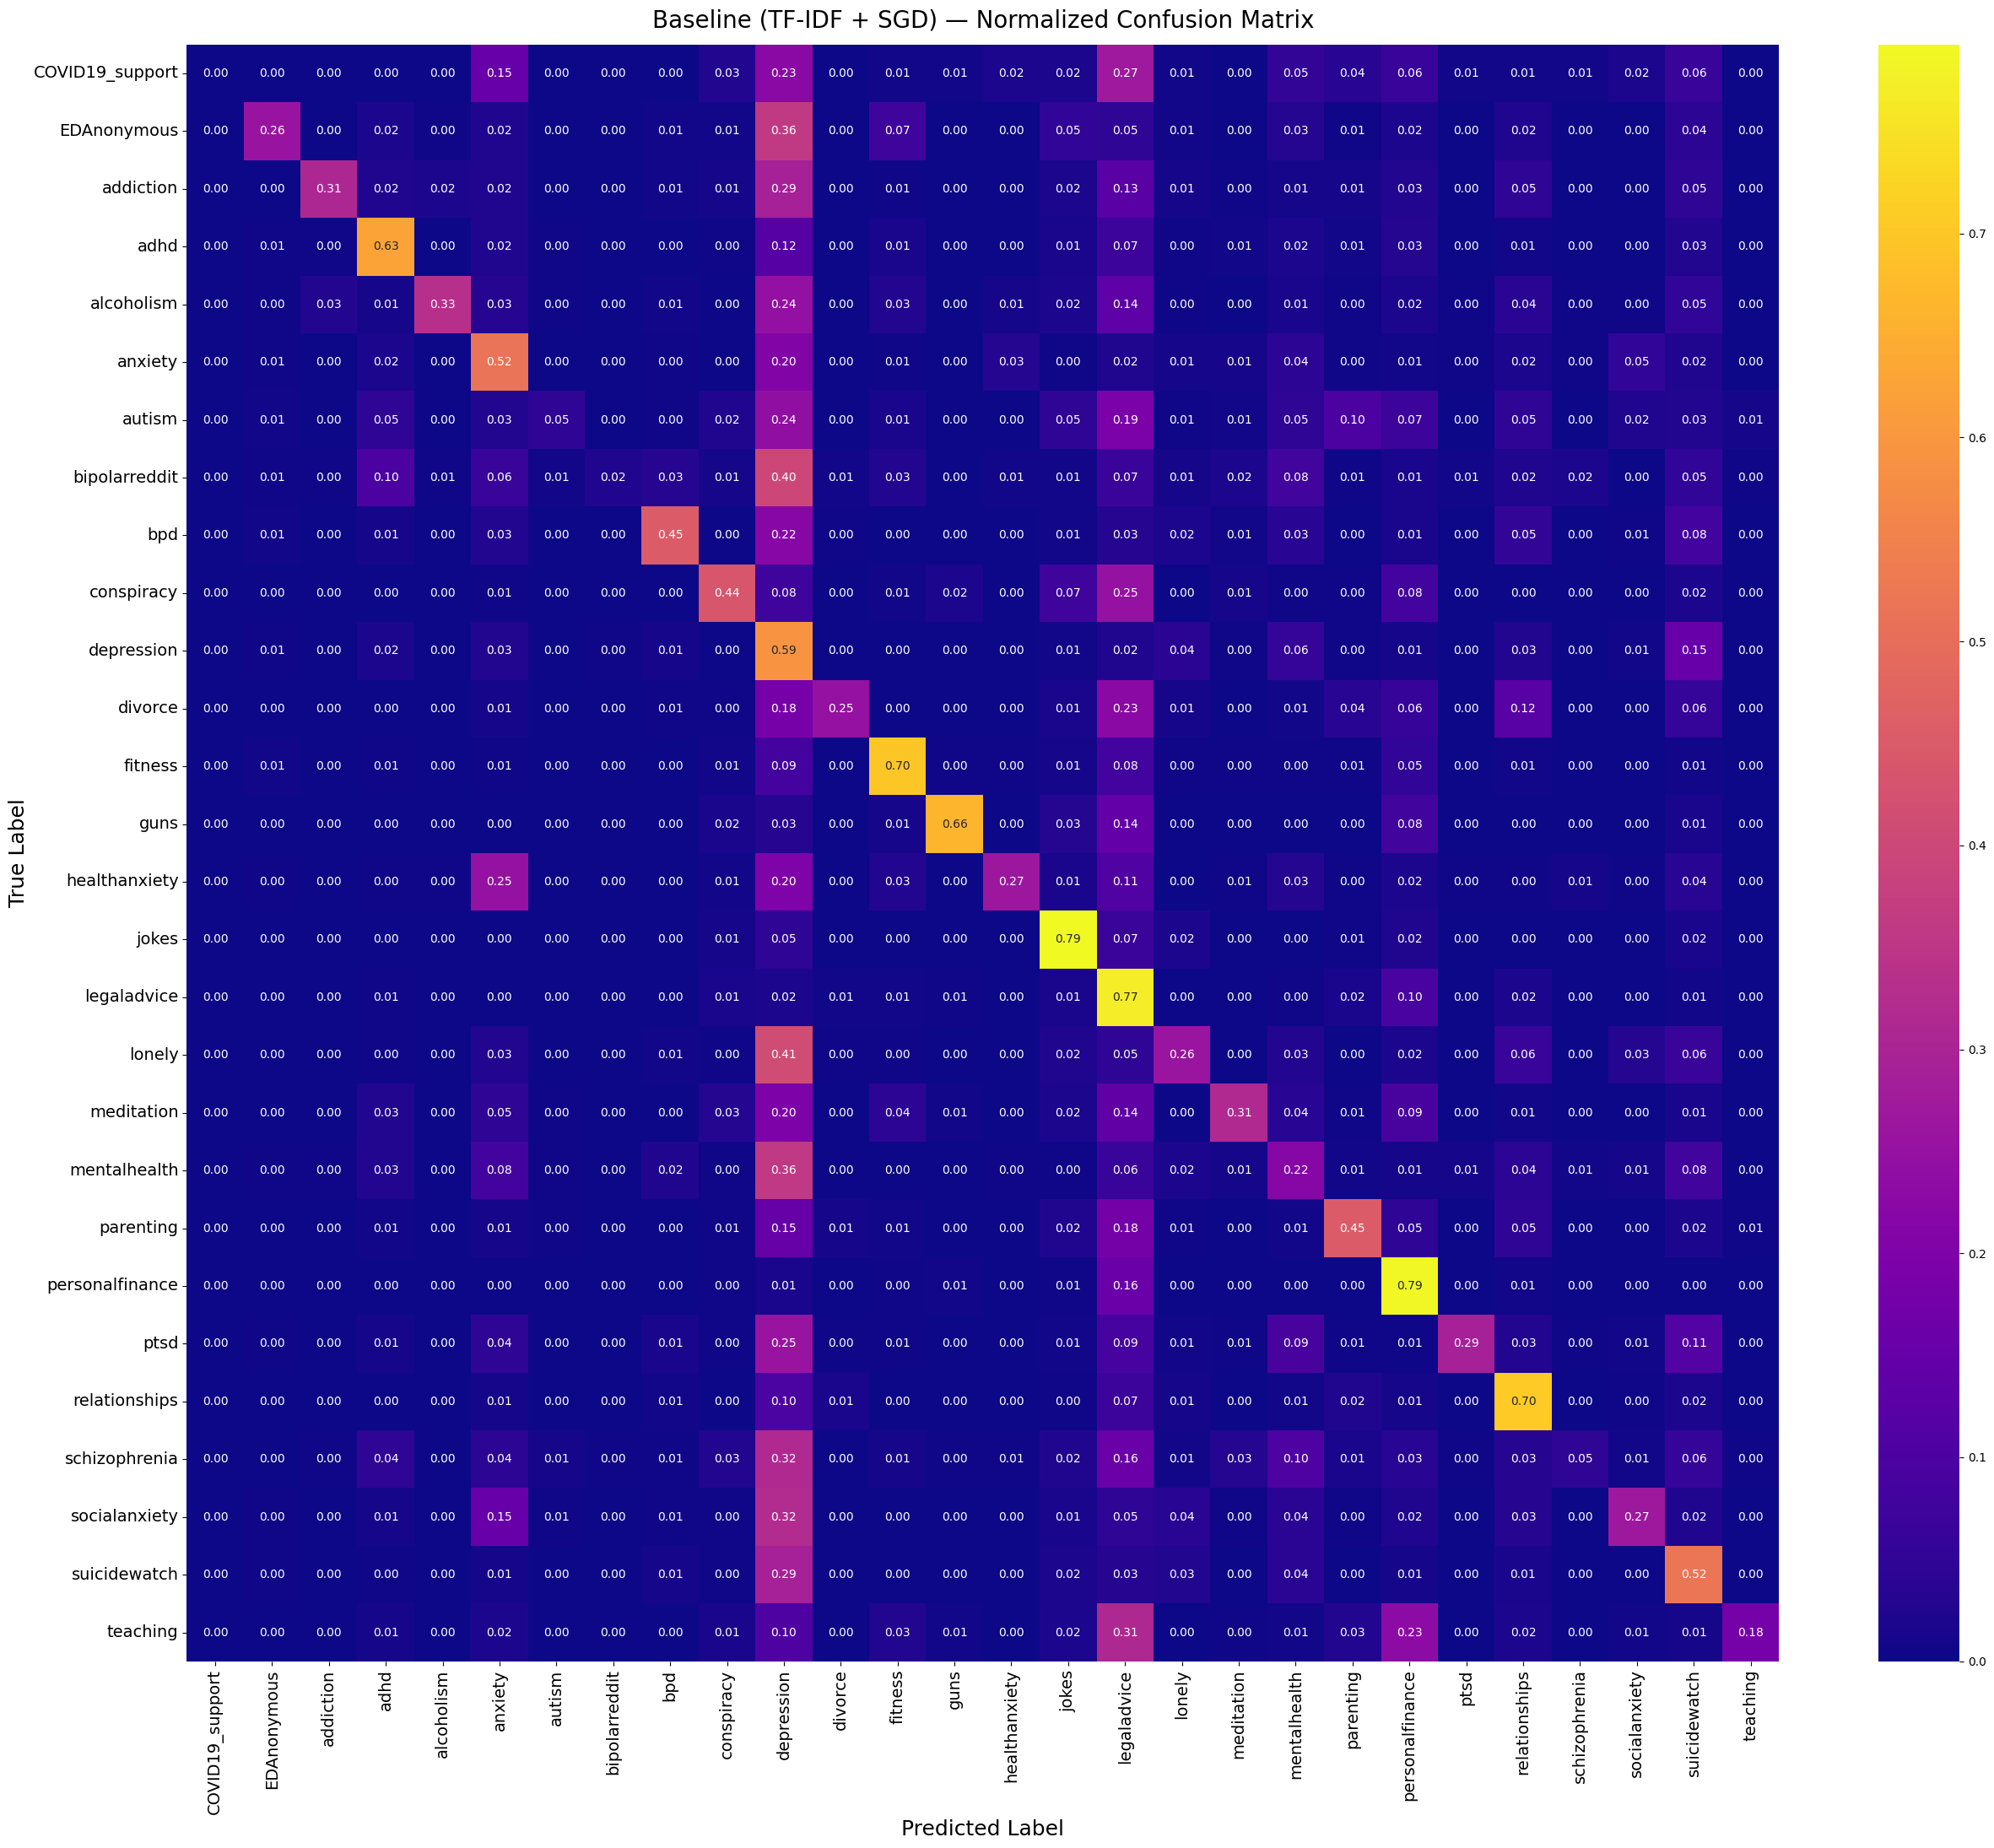

In [20]:
# CELL 5 — ✅ Baseline (SGD) with Clean Confusion Matrix

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Faster Baseline Alpha Search
# ===============================
alpha_grid = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
best_alpha, best_f1, best_clf = None, -1, None

for a in alpha_grid:
    clf = SGDClassifier(
        loss="log_loss",
        penalty="l1",
        alpha=a,
        max_iter=1000,        # keep search fast
        random_state=42
    )
    clf.fit(X_train_base, y_train)
    y_val_pred = clf.predict(X_val_base)
    f1 = f1_score(y_val, y_val_pred, average="macro")
    print(f"Alpha={a:.0e} | Val F1={f1:.4f}")
    if f1 > best_f1:
        best_alpha, best_f1, best_clf = a, f1, clf

# ===============================
# Final Baseline Model
# ===============================
sgd_clf = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    alpha=best_alpha,
    max_iter=3000,
    random_state=42
)
sgd_clf.fit(X_train_base, y_train)

print("\nBest alpha:", best_alpha, "Val F1:", best_f1)

# ===============================
# Validation Evaluation
# ===============================
y_val_pred = sgd_clf.predict(X_val_base)
print("\n=== Baseline Validation ===")
print(classification_report(y_val, y_val_pred, target_names=le_sub.classes_))

# ===============================
# Test Evaluation
# ===============================
y_test_pred = sgd_clf.predict(X_test_base)
print("\n=== Baseline Test ===")
print(classification_report(y_test, y_test_pred, target_names=le_sub.classes_))

# ===============================
# Confusion Matrix — Pretty Version
# ===============================
cm_base = confusion_matrix(y_test, y_test_pred, labels=np.arange(num_classes))
cm_base = cm_base.astype('float') / cm_base.sum(axis=1, keepdims=True)
cm_base = np.nan_to_num(cm_base)  # avoid NaNs if any class has 0 samples

plt.figure(figsize=(26, 22))
sns.heatmap(
    cm_base,
    annot=True,
    fmt=".2f",  # 2-decimal formatting, clean
    cmap="plasma",
    xticklabels=le_sub.classes_,
    yticklabels=le_sub.classes_,
    cbar=True
)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("Baseline (TF-IDF + SGD) — Normalized Confusion Matrix", fontsize=20, pad=15)
plt.tight_layout()
plt.show()


In [21]:
# CELL 6
print("\nExtracting MPNet embeddings...")
model_embed = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)

E_train = model_embed.encode(train_df["post"].tolist(), batch_size=256, show_progress_bar=True, device=device)
E_val   = model_embed.encode(val_df["post"].tolist(),   batch_size=256, show_progress_bar=True, device=device)
E_test  = model_embed.encode(test_df["post"].tolist(),  batch_size=256, show_progress_bar=True, device=device)

X_train_novel = np.hstack([E_train, Xdn_train])
X_val_novel   = np.hstack([E_val,   Xdn_val])
X_test_novel  = np.hstack([E_test,  Xdn_test])

print("Novel shapes:", X_train_novel.shape, X_val_novel.shape, X_test_novel.shape)



Extracting MPNet embeddings...


Batches: 100%|██████████| 485/485 [10:16<00:00,  1.27s/it]


Novel shapes: (578872, 858) (124044, 858) (124045, 858)


[0]	train-mlogloss:3.01000	val-mlogloss:3.01590
[100]	train-mlogloss:0.63579	val-mlogloss:0.72969
[200]	train-mlogloss:0.46642	val-mlogloss:0.61530
[300]	train-mlogloss:0.38656	val-mlogloss:0.58229
[400]	train-mlogloss:0.33301	val-mlogloss:0.56678
[500]	train-mlogloss:0.29255	val-mlogloss:0.55814
[600]	train-mlogloss:0.26027	val-mlogloss:0.55286
[700]	train-mlogloss:0.23385	val-mlogloss:0.54950
[800]	train-mlogloss:0.21150	val-mlogloss:0.54760
[900]	train-mlogloss:0.19236	val-mlogloss:0.54673
[999]	train-mlogloss:0.17583	val-mlogloss:0.54646

=== Novelty (MPNet+XGB) Test ===
                 precision    recall  f1-score   support

COVID19_support       0.71      0.14      0.23       111
    EDAnonymous       0.86      0.76      0.81      1458
      addiction       0.83      0.71      0.76       775
           adhd       0.85      0.85      0.85      4766
     alcoholism       0.82      0.78      0.80       629
        anxiety       0.67      0.70      0.69      5882
         autism   

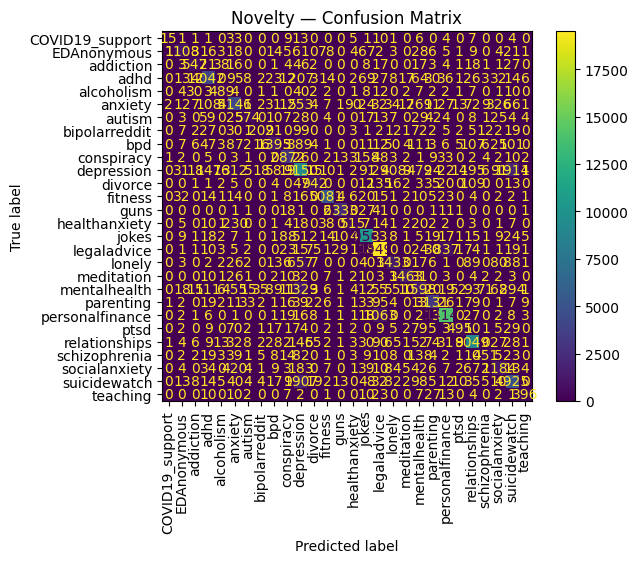

In [22]:
# CELL 7 — ✅ Version-Compatible XGBoost with Early Stopping

import xgboost as xgb

# Convert data to DMatrix (XGBoost's native format)
dtrain = xgb.DMatrix(X_train_novel, label=y_train)
dval   = xgb.DMatrix(X_val_novel,   label=y_val)
dtest  = xgb.DMatrix(X_test_novel,  label=y_test)

params = {
    "objective": "multi:softmax",   # or "multi:softprob" if you want probabilities
    "num_class": len(le_sub.classes_),
    "eval_metric": "mlogloss",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

evals = [(dtrain, "train"), (dval, "val")]

# train with early stopping
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=100
)

# Predict
y_pred = xgb_model.predict(dtest)
print("\n=== Novelty (MPNet+XGB) Test ===")
print(classification_report(y_test, y_pred, target_names=le_sub.classes_))

# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le_sub.classes_, xticks_rotation=90)
plt.title("Novelty — Confusion Matrix")
plt.show()


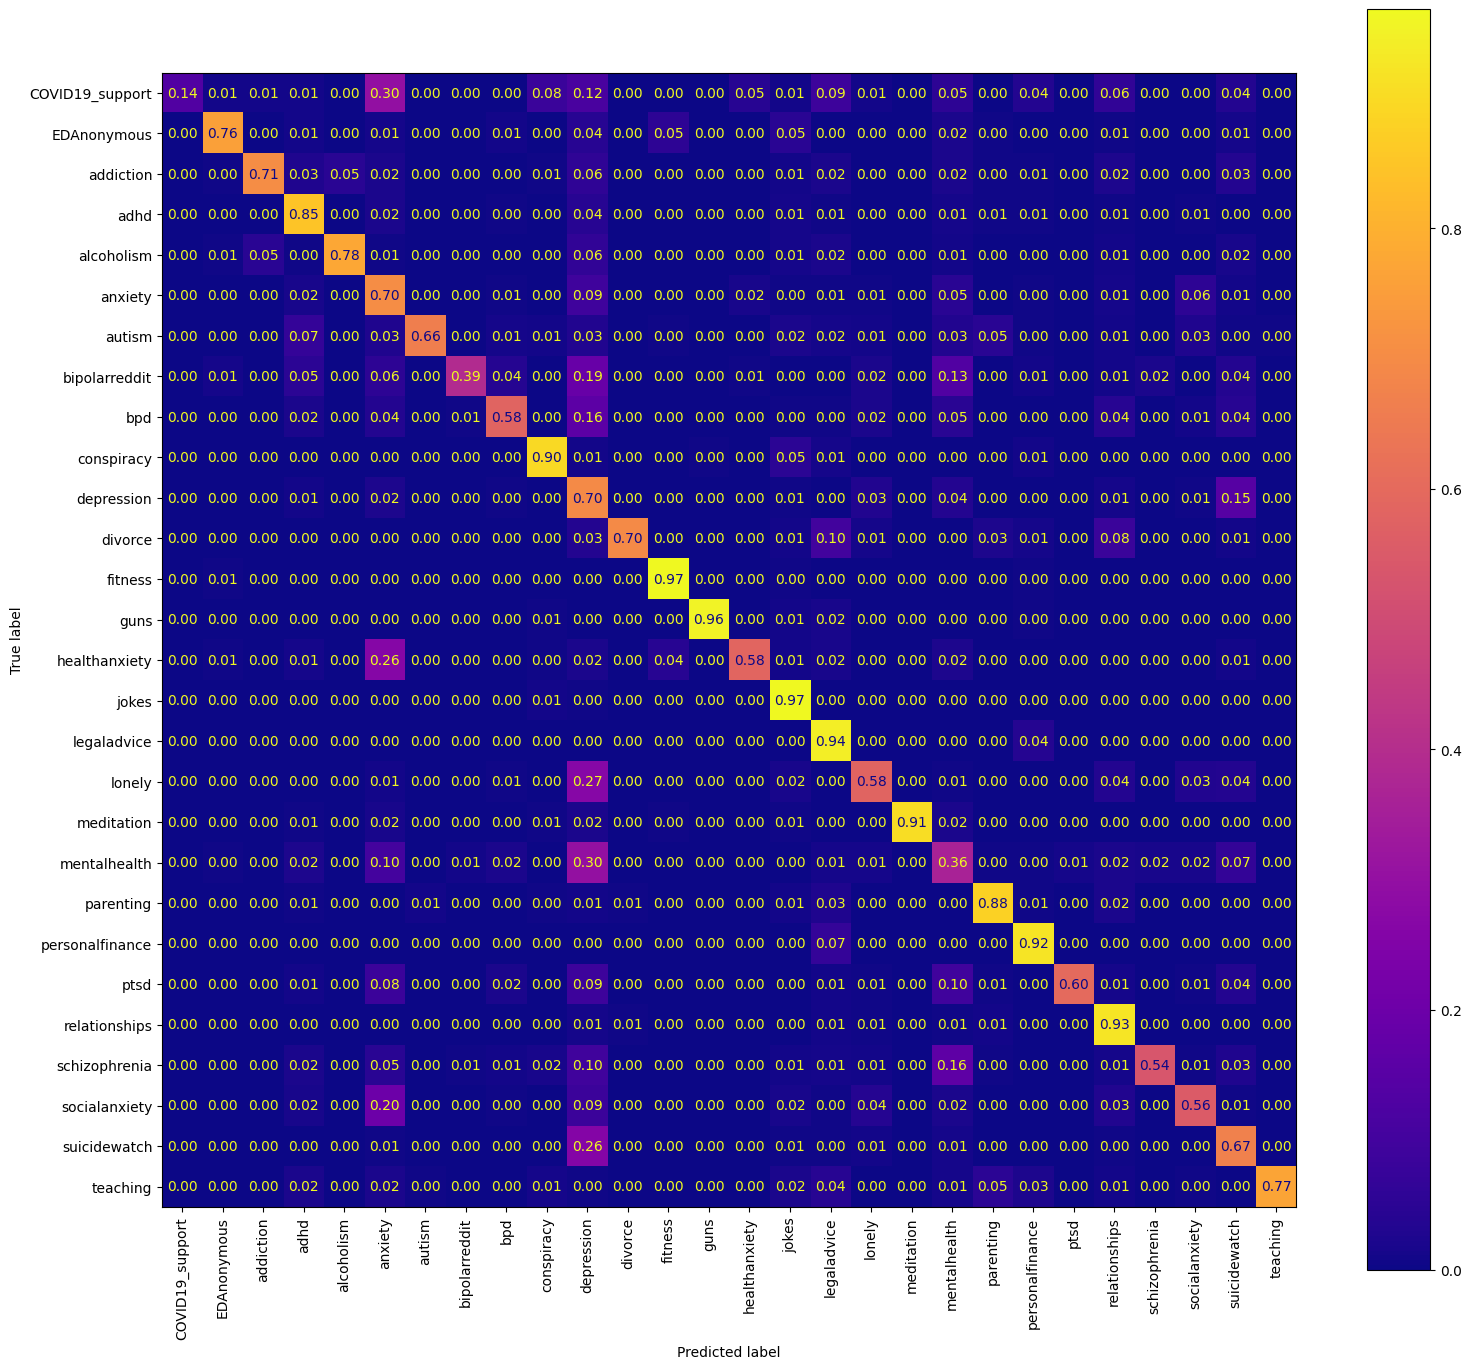

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute normalized confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(16, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le_sub.classes_)
disp.plot(
    cmap='plasma',        # nice contrast vs baseline's viridis
    xticks_rotation=90,
    values_format='.2f',
    colorbar=True,
    ax=ax
)
#ax.set_title("Novelty (MPNet + XGBoost) — Normalized Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()


In [17]:
import joblib

joblib.dump({
    "tfidf": tfidf_cols,
    "scaler": scaler,
    "label_encoder": le_sub,
    "xgb_model": xgb_model,  # save the trained Booster object
    "embedding_model_name": "sentence-transformers/all-mpnet-base-v2",  # save model name, not object
    "version": "1.0-baseline+mpnet-xgb"
}, "final_subreddit_pipeline.pkl", compress=3)

print("✅ Saved complete pipeline to final_subreddit_pipeline.pkl")


✅ Saved complete pipeline to final_subreddit_pipeline.pkl


In [24]:
# CELL 9
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ===============================
# Dataset Class
# ===============================
class SubredditDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SubredditDataset(X_train_novel, y_train)
val_ds   = SubredditDataset(X_val_novel,   y_val)
test_ds  = SubredditDataset(X_test_novel,  y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# ===============================
# Model Definition
# ===============================
in_dim = X_train_novel.shape[1]
hidden1 = 512
hidden2 = 256

class MLPClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLPClassifier(in_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ===============================
# Training Loop with Early Stopping
# ===============================
patience = 7
best_val_loss = float('inf')
wait = 0
num_epochs = 50

Epoch 01 | Train Loss=0.7327 | Val Loss=0.6117 | Val Acc=0.801
Epoch 02 | Train Loss=0.6538 | Val Loss=0.5932 | Val Acc=0.807
Epoch 03 | Train Loss=0.6451 | Val Loss=0.5930 | Val Acc=0.805
Epoch 04 | Train Loss=0.6410 | Val Loss=0.5888 | Val Acc=0.806
Epoch 05 | Train Loss=0.6376 | Val Loss=0.5974 | Val Acc=0.806
Epoch 06 | Train Loss=0.6358 | Val Loss=0.5880 | Val Acc=0.808
Epoch 07 | Train Loss=0.6346 | Val Loss=0.5801 | Val Acc=0.809
Epoch 08 | Train Loss=0.6326 | Val Loss=0.5772 | Val Acc=0.811
Epoch 09 | Train Loss=0.6320 | Val Loss=0.5831 | Val Acc=0.810
Epoch 10 | Train Loss=0.6318 | Val Loss=0.5936 | Val Acc=0.805
Epoch 11 | Train Loss=0.6321 | Val Loss=0.5800 | Val Acc=0.809
Epoch 12 | Train Loss=0.6308 | Val Loss=0.5745 | Val Acc=0.811
Epoch 13 | Train Loss=0.6306 | Val Loss=0.5770 | Val Acc=0.809
Epoch 14 | Train Loss=0.6304 | Val Loss=0.5787 | Val Acc=0.809
Epoch 15 | Train Loss=0.6300 | Val Loss=0.5788 | Val Acc=0.809
Epoch 16 | Train Loss=0.6305 | Val Loss=0.5787 | Val Ac

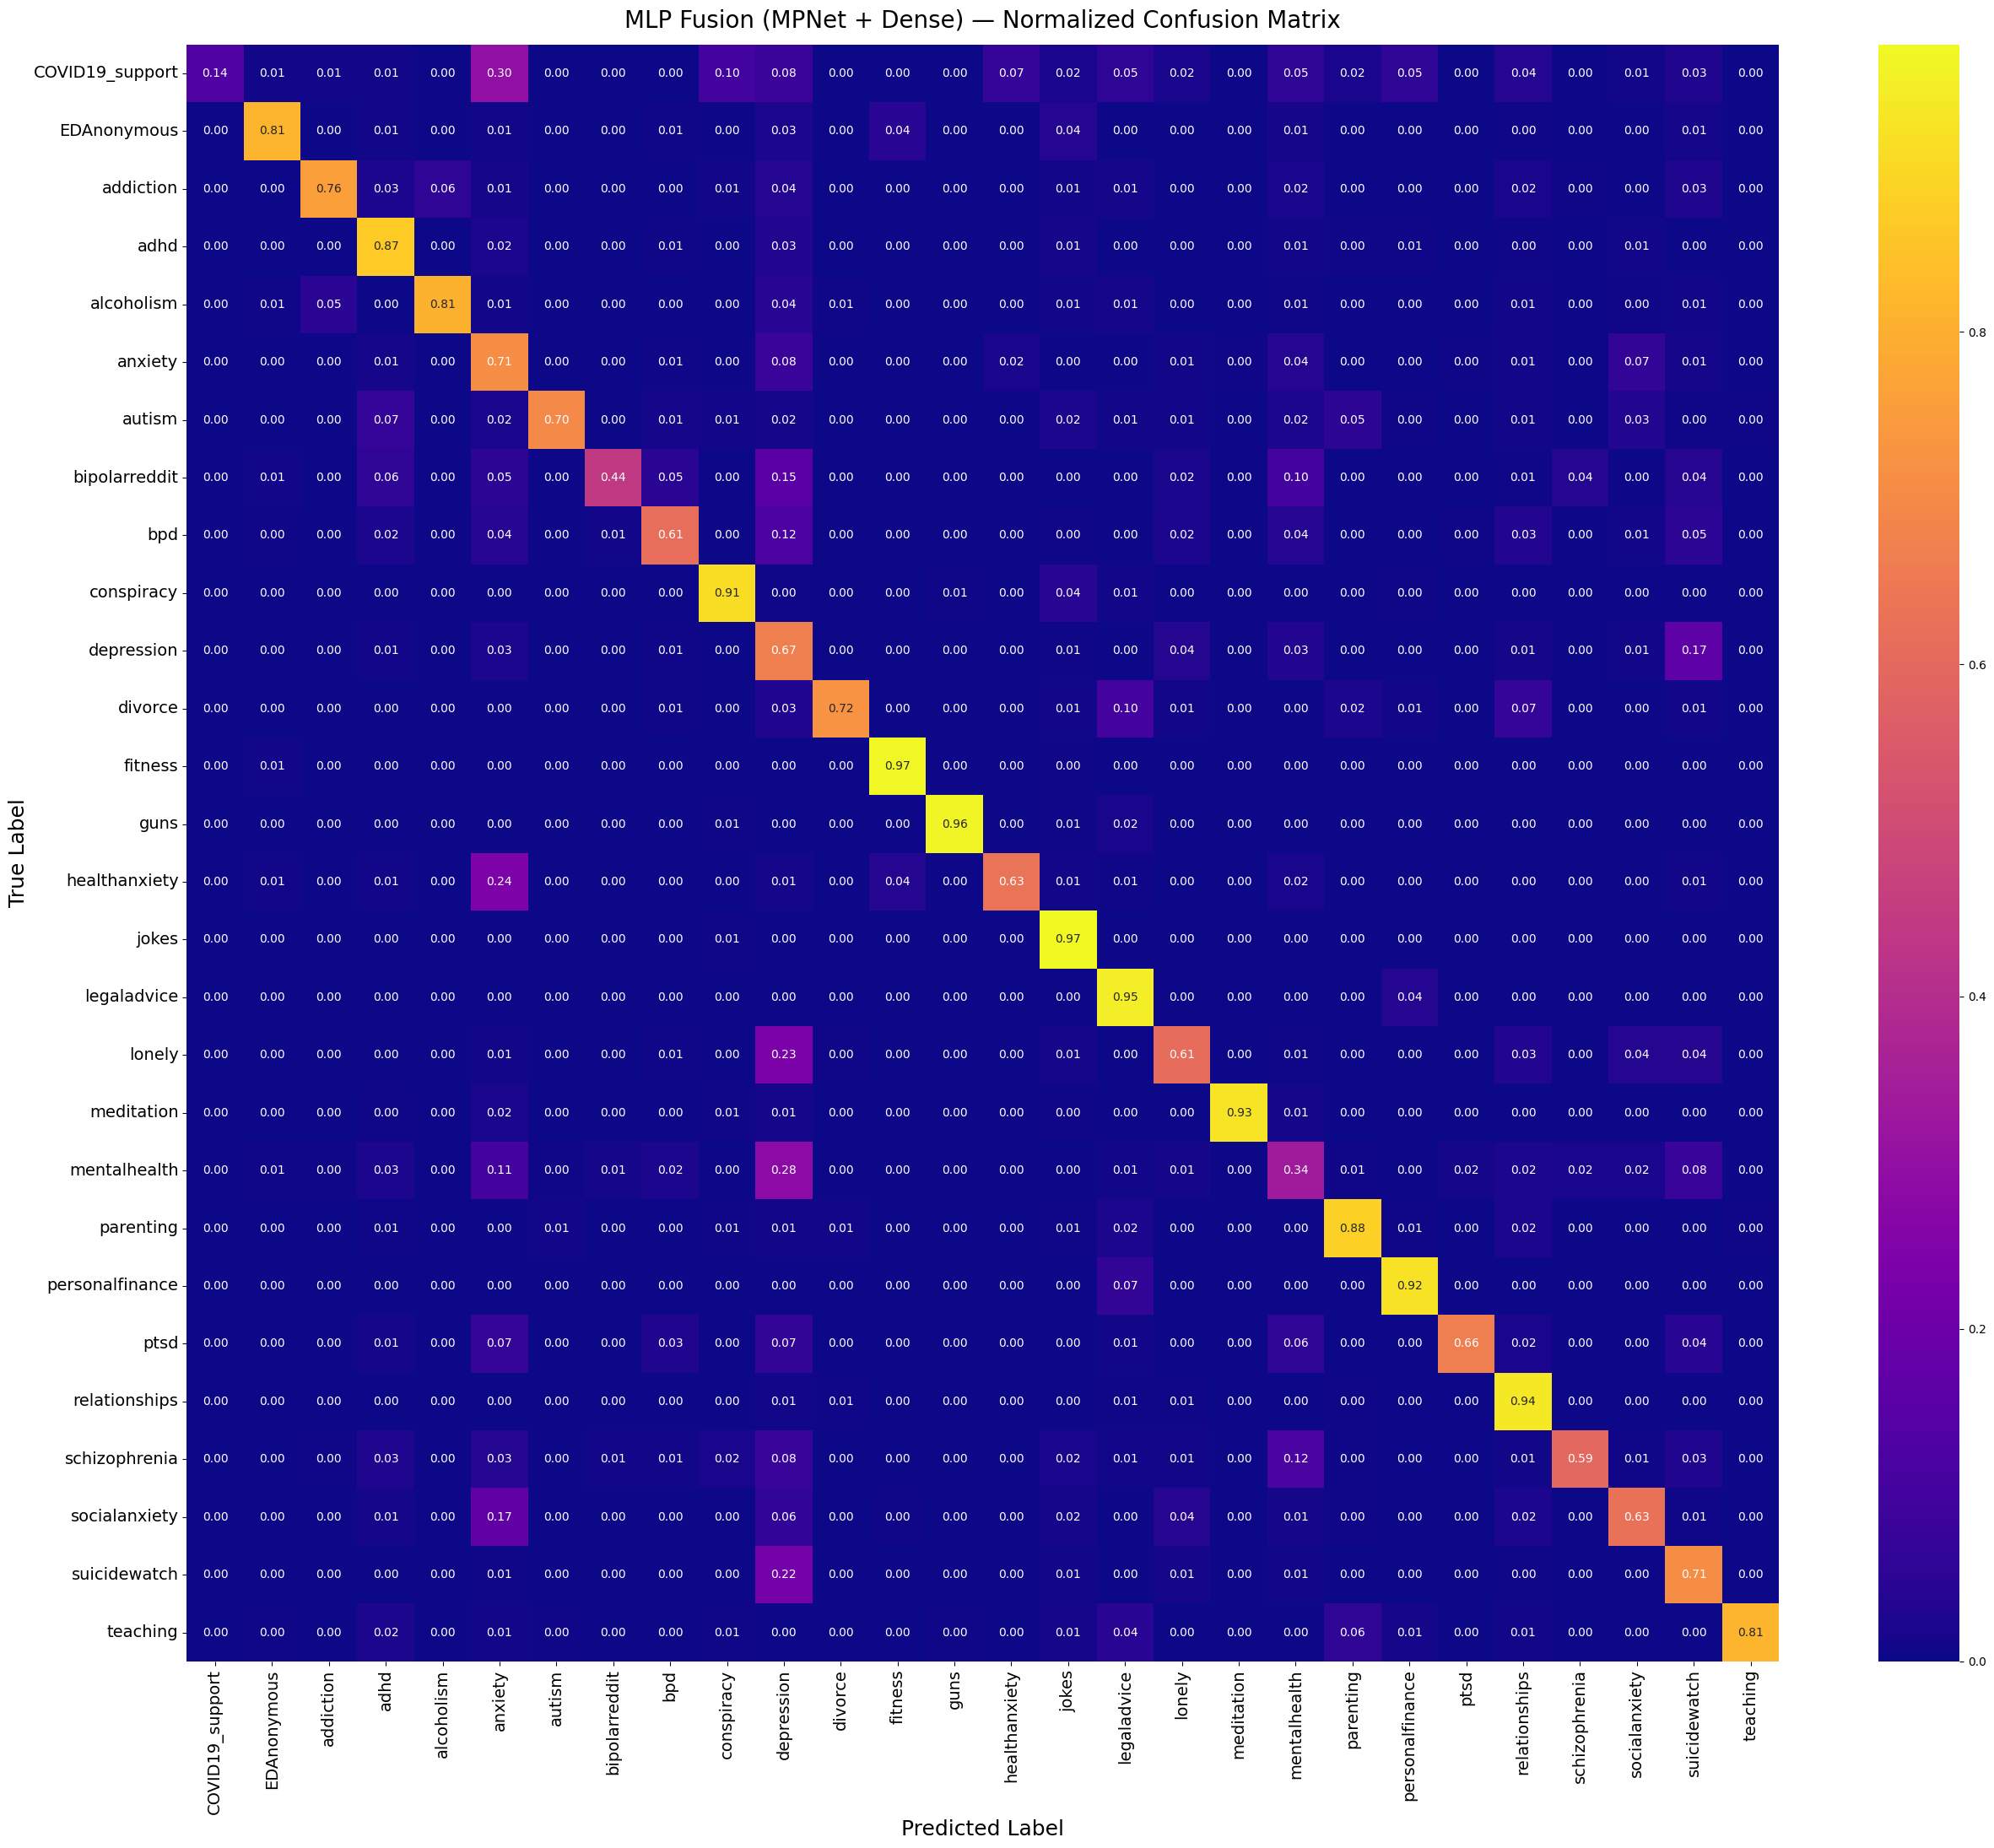

In [25]:
# CELL 9 — ✅ MLP Fusion + Pretty Confusion Matrix (Plasma, 2-decimals)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Dataset Class
# ===============================
class SubredditDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SubredditDataset(X_train_novel, y_train)
val_ds   = SubredditDataset(X_val_novel,   y_val)
test_ds  = SubredditDataset(X_test_novel,  y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# ===============================
# Model Definition
# ===============================
in_dim = X_train_novel.shape[1]
hidden1, hidden2 = 512, 256

class MLPClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLPClassifier(in_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ===============================
# Training Loop with Early Stopping
# ===============================
patience = 7
best_val_loss = float('inf')
wait = 0
num_epochs = 50

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    mlp_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = mlp_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)

    # ---- Val ----
    mlp_model.eval()
    total_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = mlp_model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    val_loss = total_loss / len(val_loader.dataset)
    val_acc = correct / total
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.3f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in mlp_model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Load best model
mlp_model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# ===============================
# Evaluation on Test Set
# ===============================
mlp_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = mlp_model(xb)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print("\n=== MLP Fusion (MPNet + Dense) Test ===")
print(classification_report(y_true, y_pred, target_names=le_sub.classes_))

# ===============================
# Confusion Matrix (Pretty)
# ===============================
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(26, 22))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",          # 2-decimal places, no dashes
    cmap="plasma",
    xticklabels=le_sub.classes_,
    yticklabels=le_sub.classes_,
    cbar=True
)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xlabel("Predicted Label", fontsize=18)
plt.ylabel("True Label", fontsize=18)
plt.title("MLP Fusion (MPNet + Dense) — Normalized Confusion Matrix", fontsize=20, pad=15)
plt.tight_layout()
plt.show()


In [2]:
import os

In [26]:
# ===============================
# Save MLP Model + Pipeline
# ===============================
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# 1. Save PyTorch MLP weights
mlp_path = os.path.join(save_dir, "mlp_fusion_model.pt")
torch.save({
    "model_state_dict": mlp_model.state_dict(),
    "in_dim": in_dim,
    "hidden1": hidden1,
    "hidden2": hidden2,
    "num_classes": num_classes,
    "label_encoder_classes": le_sub.classes_
}, mlp_path)
print(f"✅ MLP model saved to {mlp_path}")

# 2. Save preprocessing objects and embedding model using joblib
import joblib
pipeline_path = os.path.join(save_dir, "mlp_pipeline.pkl")
joblib.dump({
    "tfidf": tfidf_cols,
    "scaler": scaler,
    "label_encoder": le_sub,
    "embedding_model": model_embed,  # MPNet sentence transformer
}, pipeline_path, compress=3)
print(f"✅ Preprocessing pipeline saved to {pipeline_path}")


✅ MLP model saved to saved_models\mlp_fusion_model.pt
✅ Preprocessing pipeline saved to saved_models\mlp_pipeline.pkl


In [23]:
# Load preprocessing pipeline
pipe = joblib.load("saved_models/mlp_pipeline.pkl")
tfidf_loaded = pipe["tfidf"]
scaler_loaded = pipe["scaler"]
le_loaded = pipe["label_encoder"]
embed_loaded = pipe["embedding_model"]

# Rebuild the model
checkpoint = torch.load(
    "saved_models/mlp_fusion_model.pt",
    map_location=device,
    weights_only=False  # 👈 explicitly allow full pickle
)


mlp_loaded = MLPClassifier(
    checkpoint["in_dim"],
    checkpoint["num_classes"]
)
mlp_loaded.load_state_dict(checkpoint["model_state_dict"])
mlp_loaded = mlp_loaded.to(device).eval()
print("✅ MLP model loaded successfully")


✅ MLP model loaded successfully


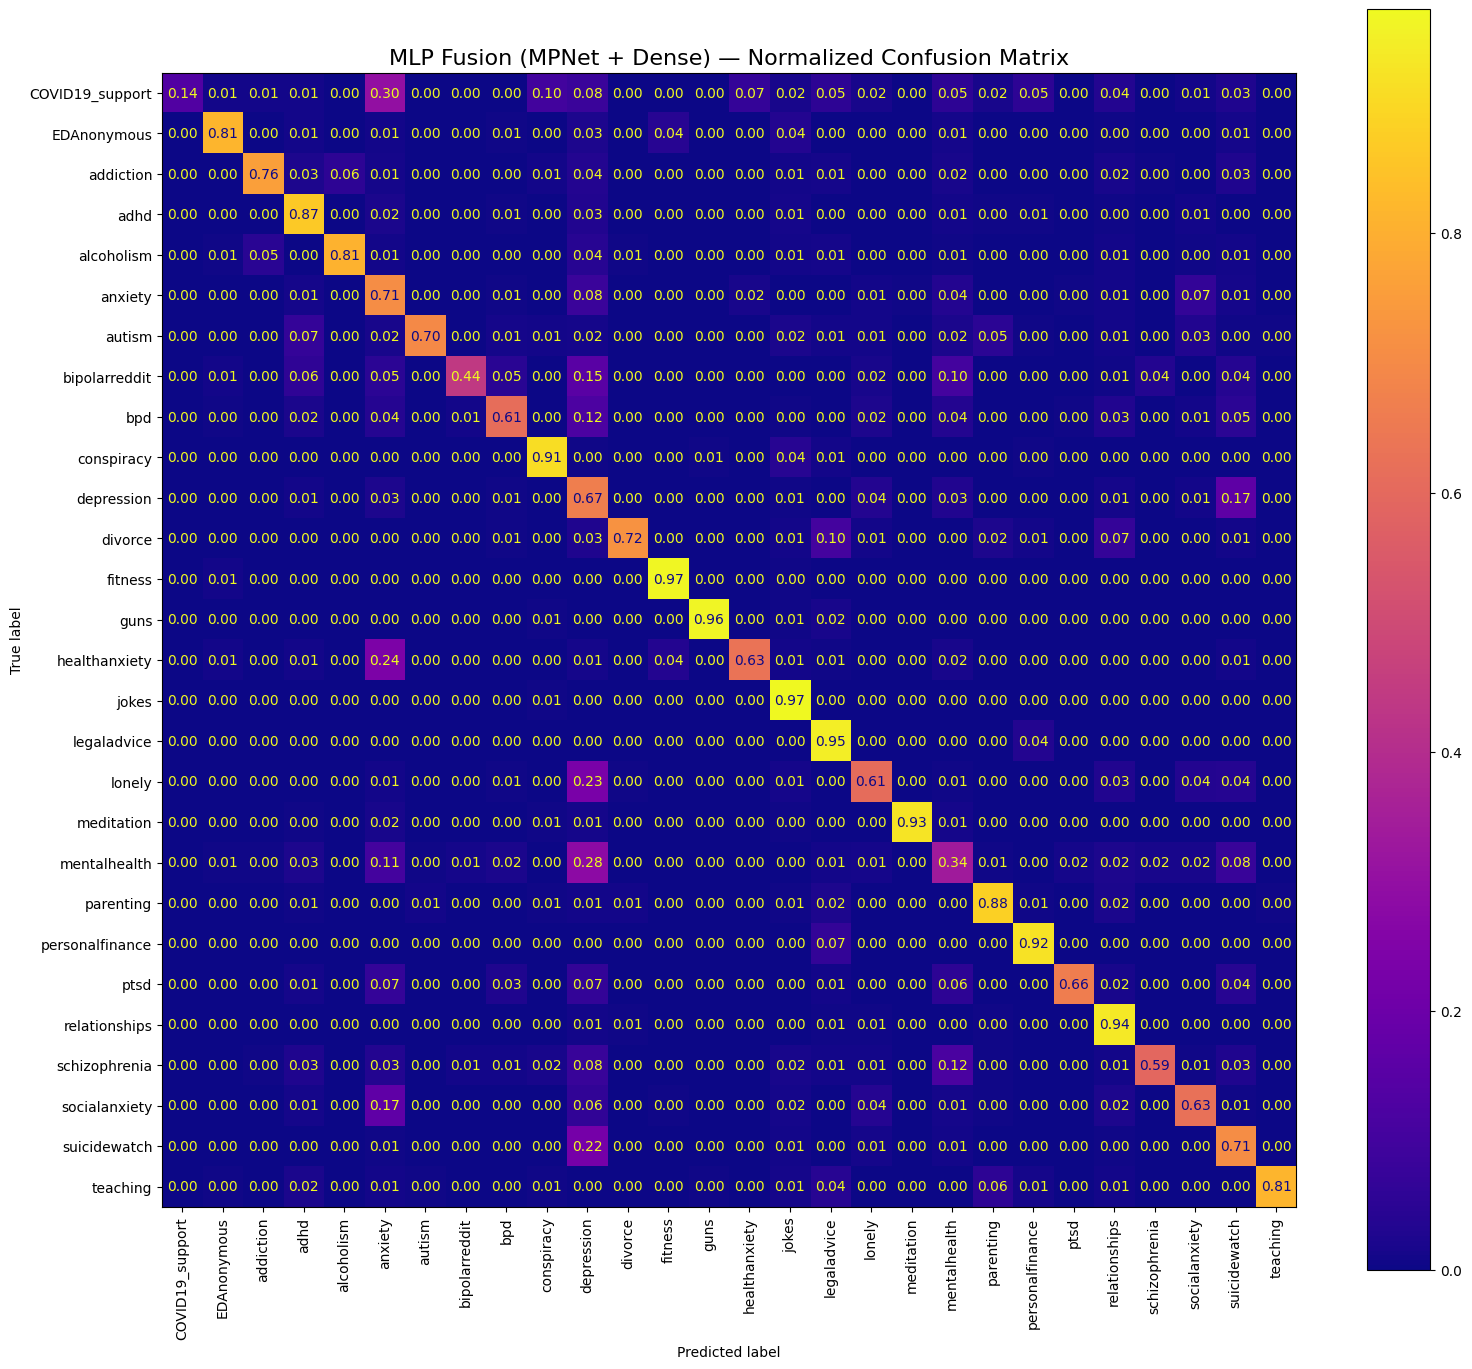

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute normalized confusion matrix for MLP
cm_mlp = confusion_matrix(y_true, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(16, 14))
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=le_sub.classes_)
disp_mlp.plot(
    cmap='plasma',         # same colormap for consistency
    xticks_rotation=90,
    values_format='.2f',   # 2 decimal values inside cells
    colorbar=True,
    ax=ax
)
ax.set_title("MLP Fusion (MPNet + Dense) — Normalized Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()




In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sgd_clf = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    alpha=best_alpha,
    max_iter=3000,    # now refit properly
    random_state=42
)
# Generate predictions
y_test_pred = sgd_clf.predict(X_test_base)

# Compute normalized confusion matrix (row-normalized)
cm = confusion_matrix(y_test, y_test_pred, normalize='true')

fig, ax = plt.subplots(figsize=(16, 14))  # bigger figure for readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_sub.classes_)
disp.plot(
    cmap='viridis', 
    xticks_rotation=90, 
    values_format='.2f', 
    colorbar=True, 
    ax=ax
)
ax.set_title("Baseline — Normalized Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'best_alpha' is not defined